# Numeric analyses
- Most clicked events 
- Most clicked players - explore info about those players
- Most liked players - explore info about those players
- Most recommended matches maybe? 

In [1]:
from database_workers.Neo4j_Event_Worker import Event_Worker
event_worker = Event_Worker()
view_players = event_worker.get_view_player_timestamps()
player_views = event_worker.get_player_view_open_timestamps()
event_worker.close()
print(len(view_players))
print(len(player_views))

729
746


We have more player views. However, only view_player has the player that was viewed.

**So we use the view_player.** 
- Player views: when a browsing page opens a player.
- View players: when an opened page has a player in the ID. This must have been less effective.

In [2]:
# Check view_player counts
from database_workers.Neo4j_Event_Worker import Event_Worker
event_worker = Event_Worker()
view_counts = event_worker.count_view_player()
like_counts = event_worker.count_like_player()
event_worker.close()
len(view_counts)

45

In [3]:
view_counts

{'Daniil Medvedev': {'total': 41,
  'preferences': 1,
  'browsing': 1,
  'browsing/player': 34,
  'browsing/parameter': 5},
 'Elise Mertens': {'total': 34, 'preferences': 4, 'browsing/player': 30},
 'Tallon Griekspoor': {'total': 17,
  'browsing/player': 14,
  'browsing/parameter': 3},
 'Felix Auger-Aliassime': {'total': 12, 'browsing/player': 12},
 'Qinwen Zheng': {'total': 11, 'browsing': 1, 'browsing/player': 10},
 'Jannik Sinner': {'total': 10, 'browsing/player': 10},
 'Belinda Bencic': {'total': 8, 'browsing/player': 8},
 'Alexander Bublik': {'total': 7, 'browsing/player': 7},
 'Alex de Minaur': {'total': 6, 'browsing/player': 6},
 'Emil Ruusuvuori': {'total': 5, 'browsing/player': 5},
 'Karolina Muchova': {'total': 4, 'browsing/player': 4},
 'Bianca Andreescu': {'total': 4, 'browsing/player': 4},
 'Liudmila Samsonova': {'total': 4, 'browsing/player': 4},
 'Varvara Gracheva': {'total': 3, 'browsing': 1, 'browsing/player': 2},
 'Maxime Cressy': {'total': 3, 'browsing/player': 2, 'b

In [4]:
print(len(like_counts))
like_counts

59


{'Daniil Medvedev': {'total': 20,
  'browsing/player': 19,
  'browsing/parameter': 1},
 'Elise Mertens': {'total': 18,
  'preferences': 1,
  'browsing/player': 16,
  'browsing/parameter': 1},
 'Felix Auger-Aliassime': {'total': 14,
  'browsing/player': 10,
  'browsing/parameter': 4},
 'Alex de Minaur': {'total': 12,
  'browsing': 6,
  'browsing/player': 5,
  'browsing/parameter': 1},
 'Tallon Griekspoor': {'total': 12,
  'browsing/player': 8,
  'browsing/parameter': 4},
 'Alexander Bublik': {'total': 11, 'browsing': 7, 'browsing/player': 4},
 'Marin Cilic': {'total': 9, 'browsing/player': 5, 'browsing/parameter': 4},
 'Veronika Kudermetova': {'total': 7,
  'preferences': 2,
  'browsing/player': 4,
  'browsing/parameter': 1},
 'Victoria Azarenka': {'total': 7, 'browsing': 2, 'browsing/player': 5},
 'Qinwen Zheng': {'total': 6, 'browsing': 1, 'browsing/player': 5},
 'Milos Raonic': {'total': 6, 'browsing/player': 5, 'browsing/parameter': 1},
 'Borna Coric': {'total': 6, 'browsing/player'

In [5]:
# Save the view counts and like counts
import pandas as pd

# Convert dictionaries to dataframes
df_view = pd.DataFrame.from_dict(view_counts, orient='index').reset_index().rename(columns={'index': 'player', 'total': 'view_count'})
df_like = pd.DataFrame.from_dict(like_counts, orient='index').reset_index().rename(columns={'index': 'player', 'total': 'like_count'})

# Merge on the "player" column and fill missing values with 0
merged_df = pd.merge(df_view[['player', 'view_count']], df_like[['player', 'like_count']], on='player', how='outer').fillna(0)

# Convert counts to integers
merged_df['view_count'] = merged_df['view_count'].astype(int)
merged_df['like_count'] = merged_df['like_count'].astype(int)

print(merged_df.head())

##################
# Actually save it
##################
# Ensure the necessary LaTeX packages are included
latex_preamble = r"""
\usepackage{longtable}
\usepackage{booktabs}
"""

# Convert the dataframe to LaTeX format using longtable
latex_code = merged_df.to_latex(index=False, longtable=True)

# Save to a .tex file
with open("./results/view_and_like_counts.tex", "w") as file:
    file.write(latex_preamble)
    file.write(latex_code)

                  player  view_count  like_count
0        Daniil Medvedev          41          20
1          Elise Mertens          34          18
2      Tallon Griekspoor          17          12
3  Felix Auger-Aliassime          12          14
4           Qinwen Zheng          11           6


In [6]:
# Get all players names from the database
from database_workers.Neo4j_Player_Worker import Player_Worker
player_worker = Player_Worker()
player_names = player_worker.get_player_names()
player_worker.close()
# Turn it from a list of dictionaries with key name to list of strings
player_names = [player['name'] for player in player_names]
print(len(player_names))
player_names[:10]

115


['Adrian Mannarino',
 'Alec Deckers',
 'Alex de Minaur',
 'Alexander Bublik',
 'Alexei Popyrin',
 'Aliaksandra Sasnovich',
 'Alison Riske-Amritraj',
 'Ana Konjuh',
 'Andrea Vavassori',
 'Ankita Raina']

## Describe player view and like counts

        total  preferences  browsing  browsing/player  browsing/parameter
count  115.00       115.00    115.00           115.00              115.00
mean     1.97         0.04      0.04             1.79                0.10
std      5.47         0.38      0.20             4.75                0.56
min      0.00         0.00      0.00             0.00                0.00
25%      0.00         0.00      0.00             0.00                0.00
50%      0.00         0.00      0.00             0.00                0.00
75%      2.00         0.00      0.00             2.00                0.00
max     41.00         4.00      1.00            34.00                5.00

Sum of all columns:
total                 227
preferences             5
browsing                5
browsing/player       206
browsing/parameter     11
dtype: int64


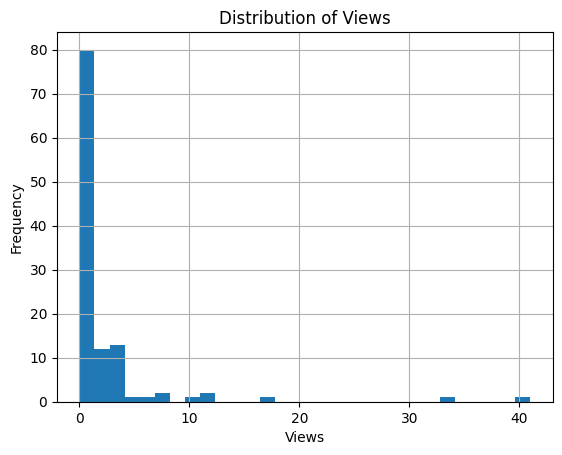

Daniil Medvedev          41
Elise Mertens            34
Tallon Griekspoor        17
Felix Auger-Aliassime    12
Qinwen Zheng             11
Jannik Sinner            10
Belinda Bencic            8
Alexander Bublik          7
Alex de Minaur            6
Emil Ruusuvuori           5
Name: total, dtype: int64
Adrian Mannarino           preferences
Alec Deckers           browsing/player
Alex de Minaur         browsing/player
Alexander Bublik       browsing/player
Alexei Popyrin             preferences
                            ...       
Yanina Wickmayer           preferences
Ysaline Bonaventure        preferences
Yue Yuan                   preferences
Zeynep Sonmez              preferences
Zizou Bergs                preferences
Length: 115, dtype: object


In [7]:
import pandas as pd
import matplotlib.pyplot as plt

# Create a DataFrame with player names as indices and initial views as 0
df_zero_views = pd.DataFrame(0, index=player_names, columns=['total', 'preferences', 'browsing', 'browsing/player', 'browsing/parameter'])

# Convert view_counts dictionary into a DataFrame
df_view_counts = pd.DataFrame(view_counts).T

# Update the df_zero_views DataFrame with the actual view counts
# This will keep 0 for players not found in view_counts
df_zero_views.update(df_view_counts)

# Replace NaN values with 0
df_zero_views = df_zero_views.fillna(0)

# Now, you can use df_zero_views for your analysis
print(df_zero_views.describe().round(2))
print("\nSum of all columns:")
print(df_zero_views.sum())

# Distribution Analysis
df_zero_views['total'].hist(bins=30)
plt.title('Distribution of Views')
plt.xlabel('Views')
plt.ylabel('Frequency')
# Save the figure
plt.savefig('./plots/total_view_distribution.png')
plt.show()

# Top viewed players
print(df_zero_views['total'].nlargest(10))

# Page from which players are viewed most
print(df_zero_views.drop('total', axis=1).idxmax(axis=1))


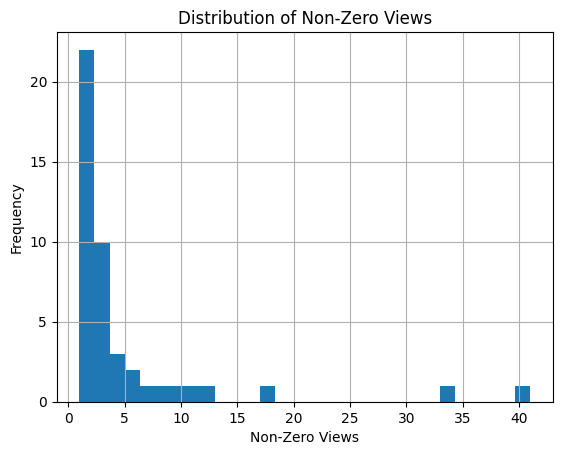

In [8]:
df_non_zero_views = df_zero_views[df_zero_views['total'] != 0]
df_non_zero_views

# Distribution Analysis
df_non_zero_views['total'].hist(bins=30)
plt.title('Distribution of Non-Zero Views')
plt.xlabel('Non-Zero Views')
plt.ylabel('Frequency')
# Save the figure
plt.savefig('./plots/total_non_zero_view_distribution.png')
plt.show()

        total  preferences  browsing  browsing/player  browsing/parameter
count  115.00       115.00    115.00           115.00              115.00
mean     1.89         0.03      0.17             1.29                0.40
std      3.56         0.21      0.90             2.82                0.83
min      0.00         0.00      0.00             0.00                0.00
25%      0.00         0.00      0.00             0.00                0.00
50%      1.00         0.00      0.00             0.00                0.00
75%      2.00         0.00      0.00             1.00                1.00
max     20.00         2.00      7.00            19.00                4.00

Sum of all columns:
total                 217
preferences             3
browsing               20
browsing/player       148
browsing/parameter     46
dtype: int64


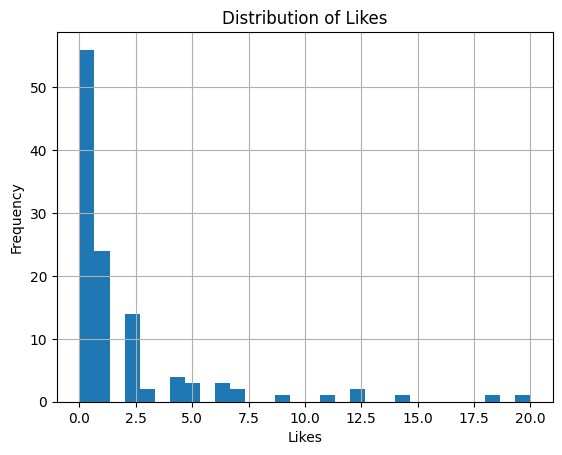

Daniil Medvedev          20
Elise Mertens            18
Felix Auger-Aliassime    14
Alex de Minaur           12
Tallon Griekspoor        12
Alexander Bublik         11
Marin Cilic               9
Veronika Kudermetova      7
Victoria Azarenka         7
Borna Coric               6
Name: total, dtype: int64
Adrian Mannarino       browsing/player
Alec Deckers               preferences
Alex de Minaur                browsing
Alexander Bublik              browsing
Alexei Popyrin         browsing/player
                            ...       
Yanina Wickmayer           preferences
Ysaline Bonaventure        preferences
Yue Yuan                   preferences
Zeynep Sonmez              preferences
Zizou Bergs                preferences
Length: 115, dtype: object


In [9]:
# Create a DataFrame with player names as indices and initial likes as 0
df_zero_likes = pd.DataFrame(0, index=player_names, columns=['total', 'preferences', 'browsing', 'browsing/player', 'browsing/parameter'])

# Convert like_counts dictionary into a DataFrame
df_like_counts = pd.DataFrame(like_counts).T

# Update the df_zero_likes DataFrame with the actual like counts
# This will keep 0 for players not found in like_counts
df_zero_likes.update(df_like_counts)

# Replace NaN values with 0
df_zero_likes = df_zero_likes.fillna(0)

# Now, you can use df_zero_likes for your analysis
print(df_zero_likes.describe().round(2))
print("\nSum of all columns:")
print(df_zero_likes.sum())

# Distribution Analysis
df_zero_likes['total'].hist(bins=30)
plt.title('Distribution of Likes')
plt.xlabel('Likes')
plt.ylabel('Frequency')
# Save the figure
plt.savefig('./plots/total_like_distribution.png')
plt.show()

# Top liked players
print(df_zero_likes['total'].nlargest(10))

# Page from which players are liked most
print(df_zero_likes.drop('total', axis=1).idxmax(axis=1))


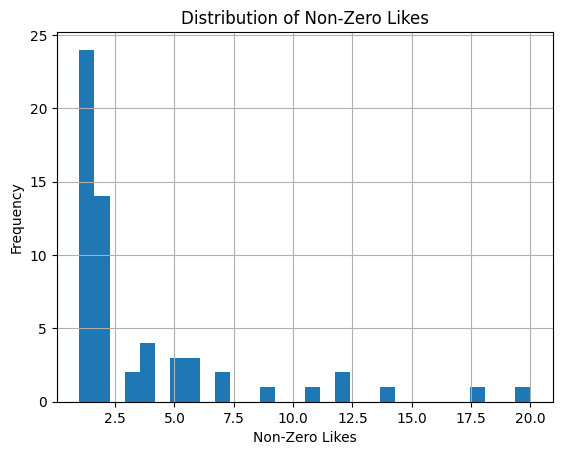

In [10]:
df_non_zero_likes = df_zero_likes[df_zero_likes['total'] != 0]

# Distribution Analysis
df_non_zero_likes['total'].hist(bins=30)
plt.title('Distribution of Non-Zero Likes')
plt.xlabel('Non-Zero Likes')
plt.ylabel('Frequency')
# Save the figure
plt.savefig('./plots/total_non_zero_like_distribution.png')
plt.show()

In [11]:
df_view_like_counts = pd.DataFrame(0, index=player_names, columns=['view_count', 'like_count'])
print(len(df_view_like_counts))
print(df_view_counts['total'].head())
print(df_like_counts['total'].head())

# Make a df that takes total from both df_view_counts and df_like_counts, renaming them view_count and like_count, merge on index
df_view_like_counts['view_count'] = df_view_counts['total']
df_view_like_counts['like_count'] = df_like_counts['total']
df_view_like_counts = df_view_like_counts.fillna(0)
print()
print(df_view_like_counts.head())

# Describe each column
print()
descriptions = df_view_like_counts.describe()
print(descriptions)

# Save descriptions as latex table
descriptions.to_latex('./results/descriptions.tex')

115
Daniil Medvedev          41.0
Elise Mertens            34.0
Tallon Griekspoor        17.0
Felix Auger-Aliassime    12.0
Qinwen Zheng             11.0
Name: total, dtype: float64
Daniil Medvedev          20.0
Elise Mertens            18.0
Felix Auger-Aliassime    14.0
Alex de Minaur           12.0
Tallon Griekspoor        12.0
Name: total, dtype: float64

                  view_count  like_count
Adrian Mannarino         0.0         2.0
Alec Deckers             3.0         0.0
Alex de Minaur           6.0        12.0
Alexander Bublik         7.0        11.0
Alexei Popyrin           0.0         2.0

       view_count  like_count
count  115.000000  115.000000
mean     1.973913    1.886957
std      5.471555    3.558447
min      0.000000    0.000000
25%      0.000000    0.000000
50%      0.000000    1.000000
75%      2.000000    2.000000
max     41.000000   20.000000


In [12]:
# Save these without rows that have 0 for both view and like count
df_view_counts_no_zero = df_view_like_counts[(df_view_like_counts['view_count'] != 0)]['view_count']
df_like_counts_no_zero = df_view_like_counts[(df_view_like_counts['like_count'] != 0)]['like_count']
description_view_counts_no_zero = df_view_counts_no_zero.describe()
description_like_counts_no_zero = df_like_counts_no_zero.describe()

print(description_view_counts_no_zero)
print(description_like_counts_no_zero)

# Merge the two descriptions
description_view_like_counts_no_zero = pd.concat([description_view_counts_no_zero, description_like_counts_no_zero], axis=1)
description_view_like_counts_no_zero.columns = ['view_count', 'like_count']
description_view_like_counts_no_zero

# Save the description to a latex table
description_view_like_counts_no_zero.to_latex('./results/description_view_like_counts_no_zero.tex')

count    45.000000
mean      5.044444
std       7.856542
min       1.000000
25%       2.000000
50%       3.000000
75%       4.000000
max      41.000000
Name: view_count, dtype: float64
count    59.000000
mean      3.677966
std       4.264693
min       1.000000
25%       1.000000
50%       2.000000
75%       4.500000
max      20.000000
Name: like_count, dtype: float64


## Get properties

In [13]:
from database_workers.Neo4j_Player_Worker import Player_Worker
# player_names = list(like_counts.keys())
# players = dict()

player_worker = Player_Worker()
# for player in player_names:
    # players[player] = player_worker.get_player_data(player)
players = player_worker.get_all_players_with_personal_data()
player_worker.close()

# Rather than a list of dictionaries, make it a dictionary of dictionaries, with the player name as the key
players = {player['name']: player for player in players}
players

{'Mackenzie McDonald': {'name': 'Mackenzie McDonald',
  'country': 'USA',
  'rank': 59,
  'rank_level': 2,
  'status': 'Qualifier',
  'experience': 2,
  'play_style': '',
  'style': None,
  'age': 28,
  'height': 178,
  'favorite_shot': 'Forehand',
  'hand': 'Right-handed',
  'personality_tags': [''],
  'personality_long': '',
  'grass_advantage': False,
  'career_high_rank': 48,
  'years_on_tour': 7,
  'coach': 'Robby Ginepri',
  'image_url': 'https://libema-open.nl/wp-content/uploads/2023/05/mcdonald_full.png',
  'gender': 'Male',
  'country_code': 'US',
  'career_high_year': 2022,
  'previous_libema_winner': False,
  'country_zone': 'North America'},
 'Corentin Moutet': {'name': 'Corentin Moutet',
  'country': 'France',
  'rank': 61,
  'rank_level': 2,
  'status': 'Qualifier',
  'experience': 2,
  'play_style': '',
  'style': None,
  'age': 24,
  'height': 175,
  'favorite_shot': 'Volley',
  'hand': 'Left-handed',
  'personality_tags': [''],
  'personality_long': '',
  'grass_advant

In [14]:
sorted(list(players['Daniil Medvedev'].keys()))

['age',
 'career_high_rank',
 'career_high_year',
 'coach',
 'country',
 'country_code',
 'country_zone',
 'experience',
 'favorite_shot',
 'gender',
 'grass_advantage',
 'hand',
 'height',
 'image_url',
 'name',
 'personality_long',
 'personality_tags',
 'play_style',
 'previous_libema_winner',
 'rank',
 'rank_level',
 'status',
 'style',
 'years_on_tour']

## Correlation analysis

In [21]:
import seaborn as sns

# Convert dictionaries to pandas DataFrames
def correlation_analysis(interactions, players, interaction_type):
    idf_numeric = pd.DataFrame(interactions).T
    pdf_numeric = pd.DataFrame(players).T

    # Drop non_numeric columns
    idf_numeric = idf_numeric.drop(['browsing'], axis=1)
    pdf_numeric = pdf_numeric[['rank', 'age', 'height', 'career_high_rank', 'career_high_year', 'years_on_tour', 'grass_advantage', 'previous_libema_winner']]
    pdf_numeric['previous_libema_winner'] = pdf_numeric['previous_libema_winner'].astype(int)

    # Replace NaN with 0
    idf_numeric = idf_numeric.fillna(0)
    pdf_numeric = pdf_numeric.fillna(0)


    # Merge the two dataframes on the index (player name)
    df = pd.merge(pdf_numeric, idf_numeric['total'], left_index=True, right_index=True)

    # Convert columns to appropriate data types
    for col in df.columns:
        df[col] = pd.to_numeric(df[col], errors='ignore')

    # Rename the total column to the interaction type
    df = df.rename(columns={'total': interaction_type})

    # Check for linearity
    for col in df.columns:
        if col != interaction_type:
            sns.lmplot(x=col, y=interaction_type, data=df, line_kws={'color': 'red'})
            plt.title(f'{col} vs. {interaction_type}')
            plt.ylabel(interaction_type)

            # save the plot in ./plots
            plt.savefig(f'./plots/{col}_vs_{interaction_type}.png')
            plt.show()

    # Calculate correlation matrix
    correlation_matrix = df.corr('kendall')

    correlation_with_total = correlation_matrix[interaction_type][:-1]
    print(correlation_with_total)

    # Now print them in order of overall magnitude (turn them all positive), from highest to lowest, , excluding the last one (which is the total itself)
    print()
    print(correlation_matrix[interaction_type][:-1].abs().sort_values(ascending=False))

    # Round the correlation matrix to 2 decimal places
    correlation_matrix_rounded = correlation_matrix.round(2)

    # Set the figure size
    plt.figure(figsize=(10, 10))

    # Plot the correlation matrix
    sns.heatmap(correlation_matrix_rounded, annot=True, cmap='coolwarm')
    # Save this in matrix, but prevent it from getting cut off
    b, t = plt.ylim() # discover the values for bottom and top
    b += 0.5 # Add 0.5 to the bottom
    t -= 0.5 # Subtract 0.5 from the top
    plt.ylim(b, t) # update the ylim(bottom, top) values
    plt.title(f'Correlation Matrix for {interaction_type}')
    # This line added:
    plt.tight_layout()
    # save the plot in ./plots
    plt.savefig(f'./plots/correlation_matrix_{interaction_type}.png')
    plt.show()


    # Return the correlation with total as a DataFrame
    # Round to 3 digits after the decimal place
    correlation_with_total = correlation_with_total.round(3)
    result = pd.DataFrame(correlation_with_total).sort_values(by=interaction_type, ascending=False)
    return result

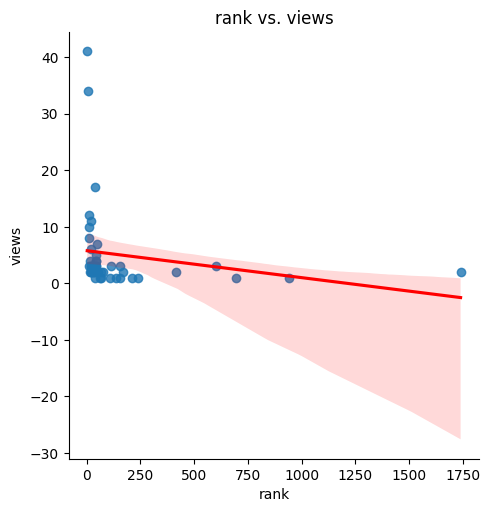

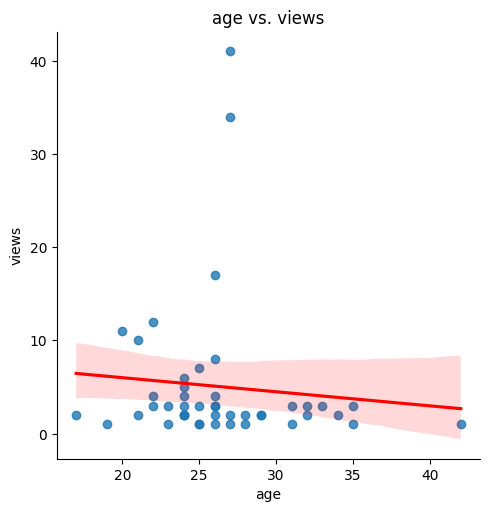

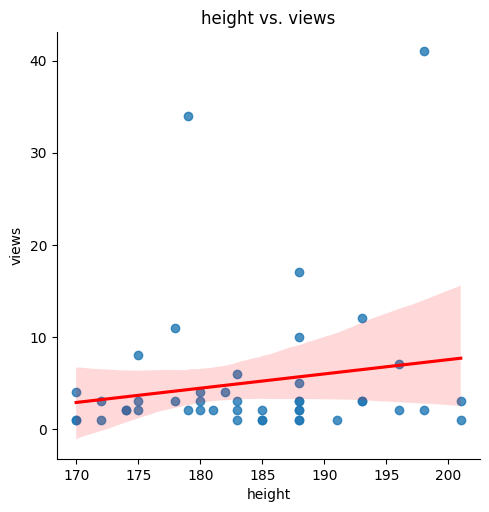

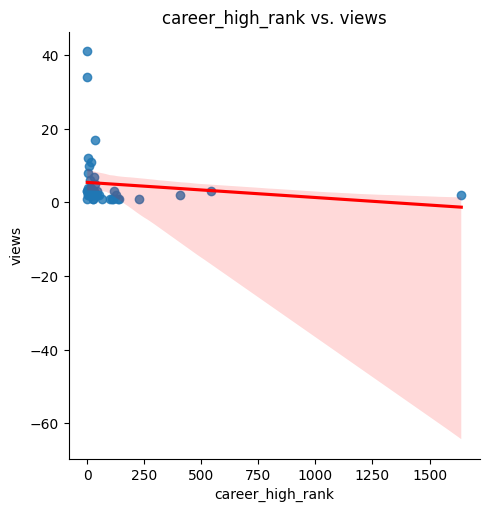

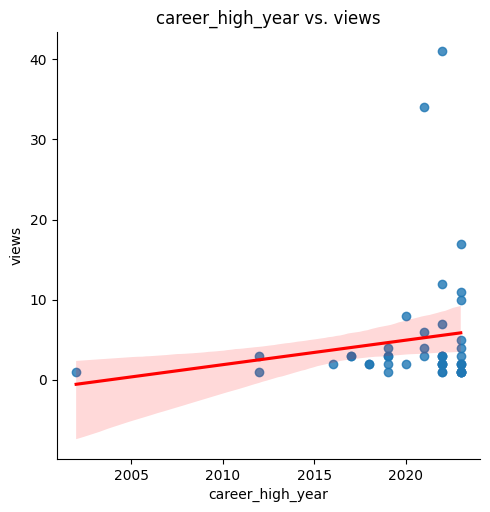

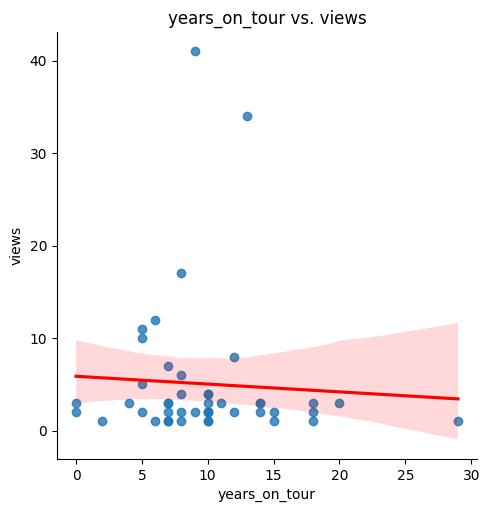

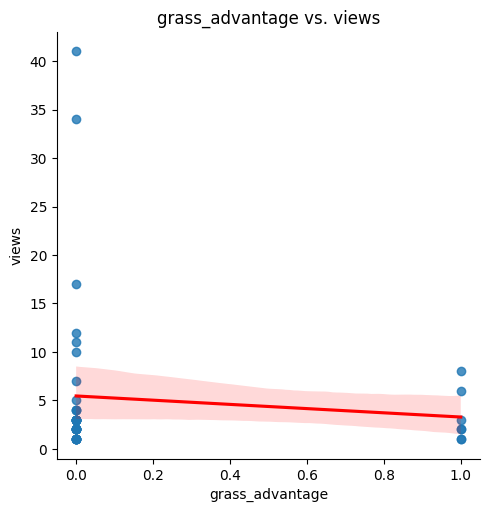

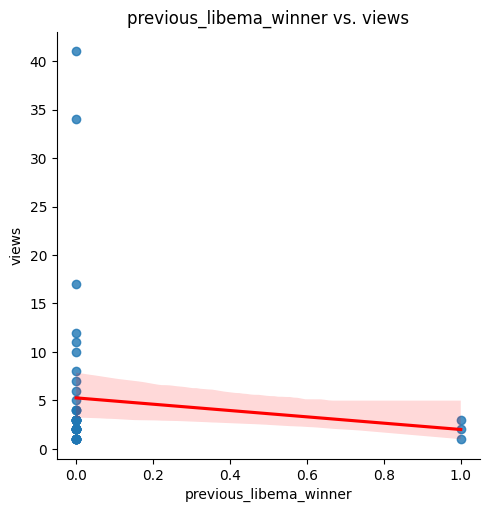

rank                     -0.487439
age                      -0.163016
height                    0.070678
career_high_rank         -0.344977
career_high_year          0.026766
years_on_tour            -0.106362
grass_advantage          -0.061590
previous_libema_winner   -0.120525
Name: views, dtype: float64

rank                      0.487439
career_high_rank          0.344977
age                       0.163016
previous_libema_winner    0.120525
years_on_tour             0.106362
height                    0.070678
grass_advantage           0.061590
career_high_year          0.026766
Name: views, dtype: float64


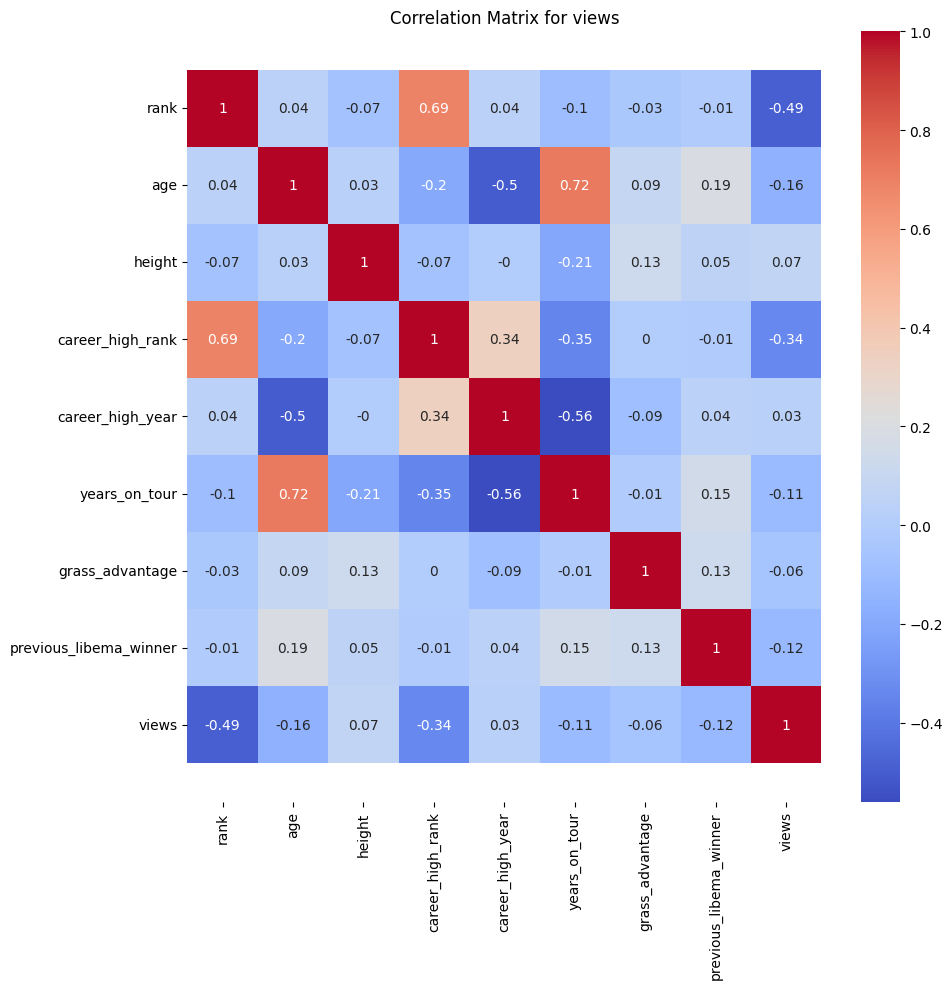

In [22]:
view_cors = correlation_analysis(view_counts, players, 'views')

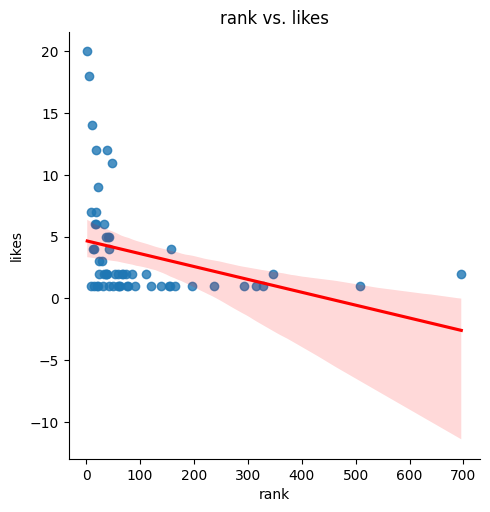

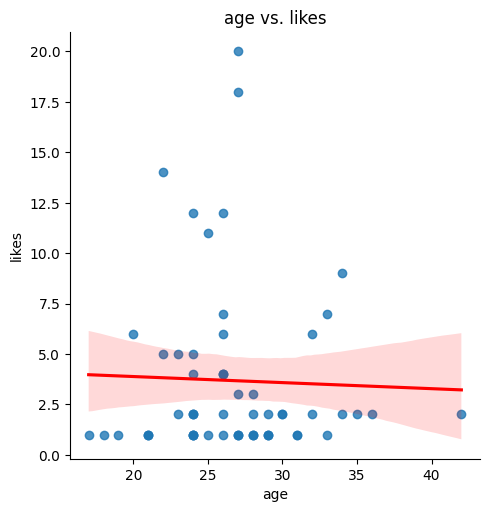

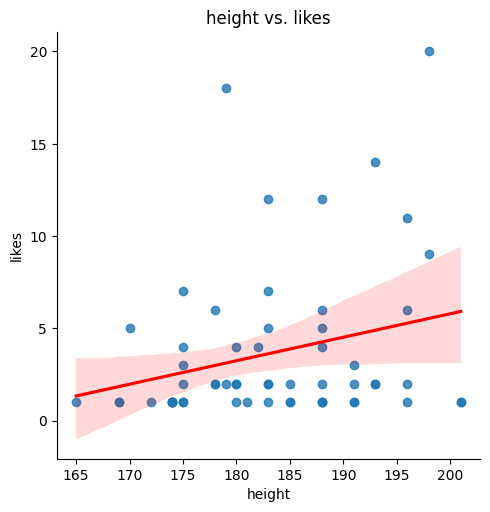

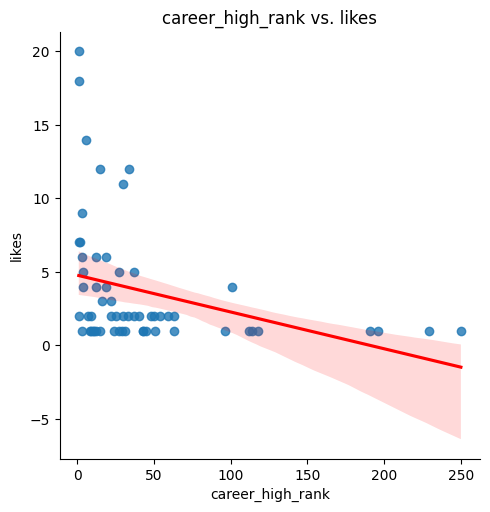

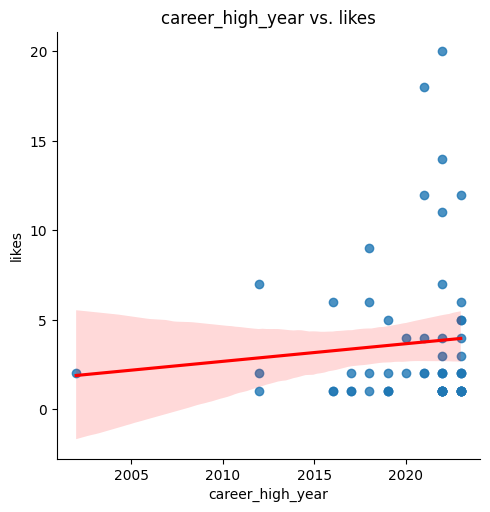

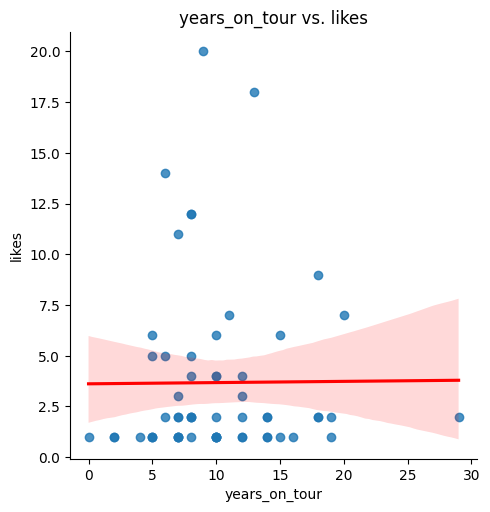

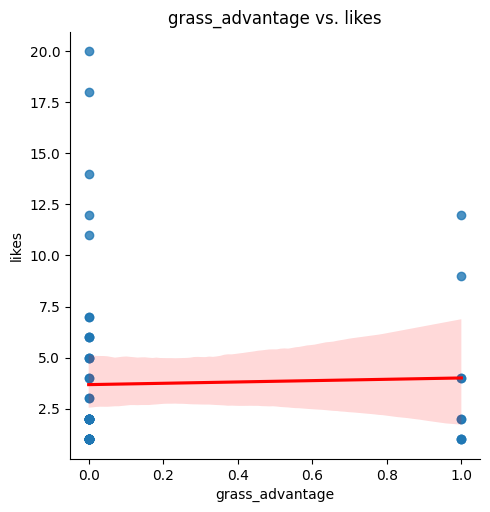

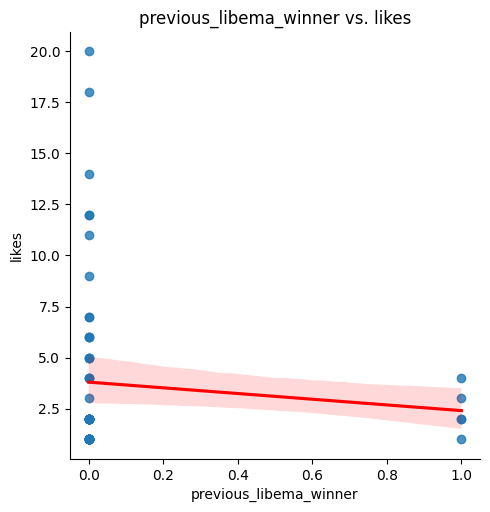

rank                     -0.450671
age                       0.016479
height                    0.194032
career_high_rank         -0.385790
career_high_year         -0.005097
years_on_tour             0.079950
grass_advantage           0.055598
previous_libema_winner    0.025041
Name: likes, dtype: float64

rank                      0.450671
career_high_rank          0.385790
height                    0.194032
years_on_tour             0.079950
grass_advantage           0.055598
previous_libema_winner    0.025041
age                       0.016479
career_high_year          0.005097
Name: likes, dtype: float64


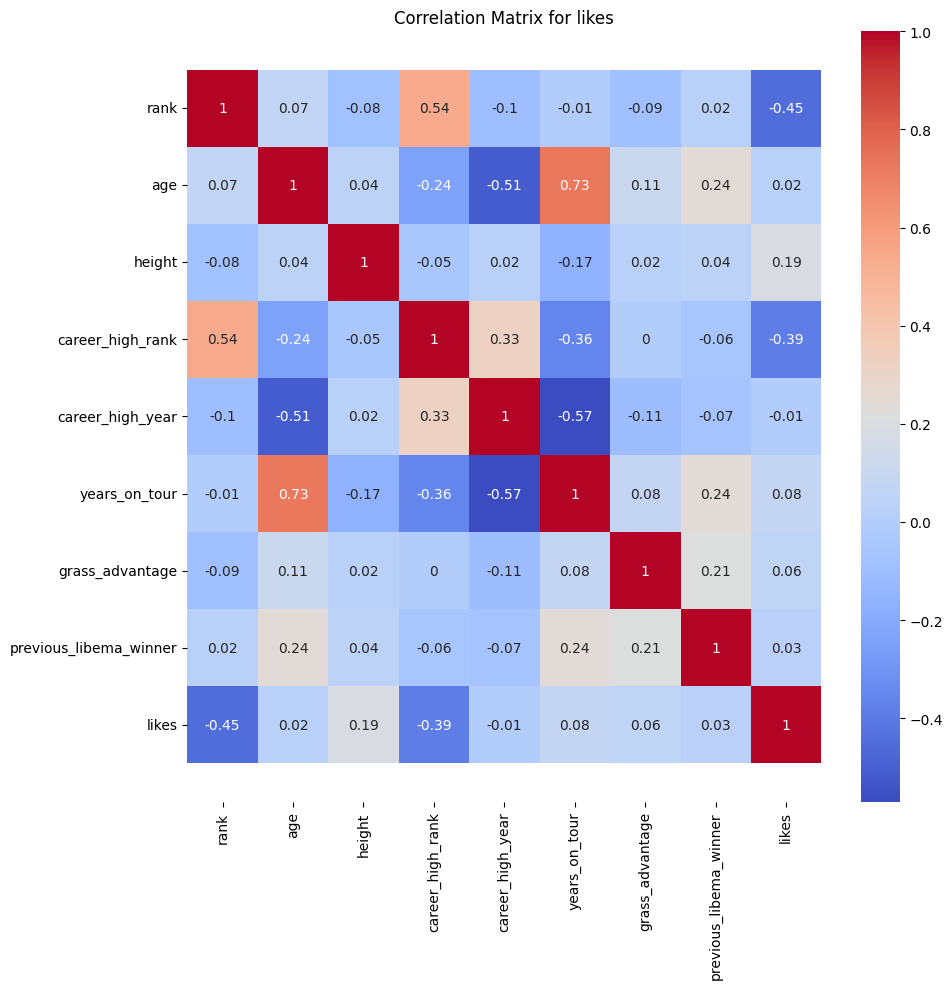

In [23]:
like_cors = correlation_analysis(like_counts, players, 'likes')

In [20]:
# Sort view cors from smallest to largest
view_cors

,views
height,0.071
career_high_year,0.027
grass_advantage,-0.062
years_on_tour,-0.106
previous_libema_winner,-0.121
age,-0.163
career_high_rank,-0.345
rank,-0.487


In [21]:
like_cors

,likes
height,0.194
years_on_tour,0.080
grass_advantage,0.056
previous_libema_winner,0.025
age,0.016
career_high_year,-0.005
career_high_rank,-0.386
rank,-0.451


In [30]:
view_cors.to_csv('./results/view_cors.csv')
like_cors.to_csv('./results/like_cors.csv')

# Edit as Latex
view_cors_tex = view_cors.copy()
like_cors_tex = like_cors.copy()
view_cors_tex.index = view_cors_tex.index.str.replace('_', ' ')
like_cors_tex.index = like_cors_tex.index.str.replace('_', ' ')

# Edit headers to LaTeX
view_cors_output = "\\textbf{Property Correlation with View Counts}\n\n"
like_cors_output = "\\textbf{Property Correlation with Like Counts}\n\n"

# Edit headers
view_cors_output += view_cors_tex.to_latex(header=False, column_format='lr')
like_cors_output += like_cors_tex.to_latex(header=False, column_format='lr')

# Print LaTeX output
print(like_cors_output)

# Save both to .tex files
with open('./results/view_cors.tex', 'w') as f:
    f.write(view_cors_output)
with open('./results/like_cors.tex', 'w') as f:
    f.write(like_cors_output)

\textbf{Property Correlation with Like Counts}

\begin{tabular}{lr}
\toprule
\midrule
height & 0.194000 \\
years on tour & 0.080000 \\
grass advantage & 0.056000 \\
previous libema winner & 0.025000 \\
age & 0.016000 \\
career high year & -0.005000 \\
career high rank & -0.386000 \\
rank & -0.451000 \\
\bottomrule
\end{tabular}



# Categorical analyses
For categorical variables, you could perform an ANOVA or Chi-squared test to determine if the variable is associated with total views.

In [23]:
def create_cat_dataframe(view_interactions, like_interactions, players):
    # Convert dictionaries to pandas DataFrames
    view_idf = pd.DataFrame(view_interactions).T
    like_idf = pd.DataFrame(like_interactions).T
    pdf = pd.DataFrame(players).T

    # Select 'total' interactions and specific player properties
    view_idf = view_idf['total']
    like_idf = like_idf['total']
    pdf = pdf[['rank', 'age', 'height', 'career_high_rank', 'career_high_year', 'years_on_tour', 'grass_advantage', 'previous_libema_winner', 'country_zone', 'favorite_shot', 'gender', 'hand', 'play_style', 'personality_tags']]

    # Convert 'previous_libema_winner' to integer
    pdf['previous_libema_winner'] = pdf['previous_libema_winner'].astype(int)

    # Merge the view interactions dataframe with the players dataframe, fill missing interactions with 0
    df = pd.merge(pdf, view_idf, how='left', left_index=True, right_index=True).fillna(0)

    # Merge the like interactions dataframe with the current dataframe, fill missing interactions with 0
    df = pd.merge(df, like_idf, how='left', left_index=True, right_index=True, suffixes=('_views', '_likes')).fillna(0)

    # Convert columns to appropriate data types
    for col in df.columns:
        df[col] = pd.to_numeric(df[col], errors='ignore', downcast='integer')

    # Sort by total_likes
    df = df.sort_values(by='total_likes', ascending=False)

    # Return the created DataFrame
    return df

In [24]:
def visualize_cat_property(df, property_name, interaction_type, types=['mean', 'sum', 'count']):
    import matplotlib.pyplot as plt
    import seaborn as sns

    valid_types = ['mean', 'sum', 'count']
    types = [t for t in types if t in valid_types]
    
    # Group data by the selected property and compute total and mean interaction counts
    grouped_data = df.groupby(property_name)[interaction_type].agg(valid_types).reset_index()

    # Create subplots for mean, sum and count
    fig, axs = plt.subplots(len(types), 1, figsize=(10, 5*len(types)))
    if len(types) == 1:
        axs = [axs]

    if 'mean' in types:
        # Bar plot for mean interaction counts
        sns.barplot(x=property_name, y='mean', data=grouped_data, ax=axs[0])
        axs[0].set_title(f'Mean {interaction_type.capitalize()} Counts by {property_name.capitalize()}')
        axs[0].set_xticklabels(axs[0].get_xticklabels(), rotation=45, horizontalalignment='right')

    if 'sum' in types:
        # Bar plot for total interaction counts
        sns.barplot(x=property_name, y='sum', data=grouped_data, ax=axs[1 if 'mean' in types else 0])
        axs[1 if 'mean' in types else 0].set_title(f'Total {interaction_type.capitalize()} Counts by {property_name.capitalize()}')
        axs[1 if 'mean' in types else 0].set_xticklabels(axs[1 if 'mean' in types else 0].get_xticklabels(), rotation=45, horizontalalignment='right')

    if 'count' in types:
        # Bar plot for player count in each category
        sns.barplot(x=property_name, y='count', data=grouped_data, ax=axs[2 if 'mean' in types and 'sum' in types else 1 if 'mean' in types or 'sum' in types else 0])
        axs[2 if 'mean' in types and 'sum' in types else 1 if 'mean' in types or 'sum' in types else 0].set_title(f'Player Counts by {property_name.capitalize()}')
        axs[2 if 'mean' in types and 'sum' in types else 1 if 'mean' in types or 'sum' in types else 0].set_xticklabels(axs[2 if 'mean' in types and 'sum' in types else 1 if 'mean' in types or 'sum' in types else 0].get_xticklabels(), rotation=45, horizontalalignment='right')

    plt.tight_layout()
    plt.show()

In [25]:
cat_df = create_cat_dataframe(view_counts, like_counts, players)
cat_df.head()

,rank,age,height,career_high_rank,career_high_year,years_on_tour,grass_advantage,previous_libema_winner,country_zone,favorite_shot,gender,hand,play_style,personality_tags,total_views,total_likes
Daniil Medvedev,2,27,198,1,2022,9,0.0,0,,Return,Male,Right-handed,Counter puncher,"[funny, outspoken, analytical, unorthodox, def...",41,20
Elise Mertens,6,27,179,1,2021,13,0.0,0,Dutch,Backhand,Female,Right-handed,Counter puncher,"[ respectful, interactive, consistent, footwor...",34,18
Felix Auger-Aliassime,11,22,193,6,2022,6,0.0,0,North America,Forehand,Male,Right-handed,Aggressive baseliner,"[respectful, powerful serve, powerful forehand...",12,14
Alex de Minaur,19,24,183,15,2021,8,1.0,0,Australia,Backhand,Male,Right-handed,Counter puncher,"[energetic, fighter, runs like crazy on every ...",6,12
Tallon Griekspoor,39,26,188,34,2023,8,0.0,0,Dutch,Forehand,Male,Right-handed,Aggressive baseliner,"[outspoken, interactive, local hero, powerful ...",17,12


In [26]:
# find rows where country_zone = Asia
cat_df.shape[0]

115

In [27]:
len(players.keys())

115

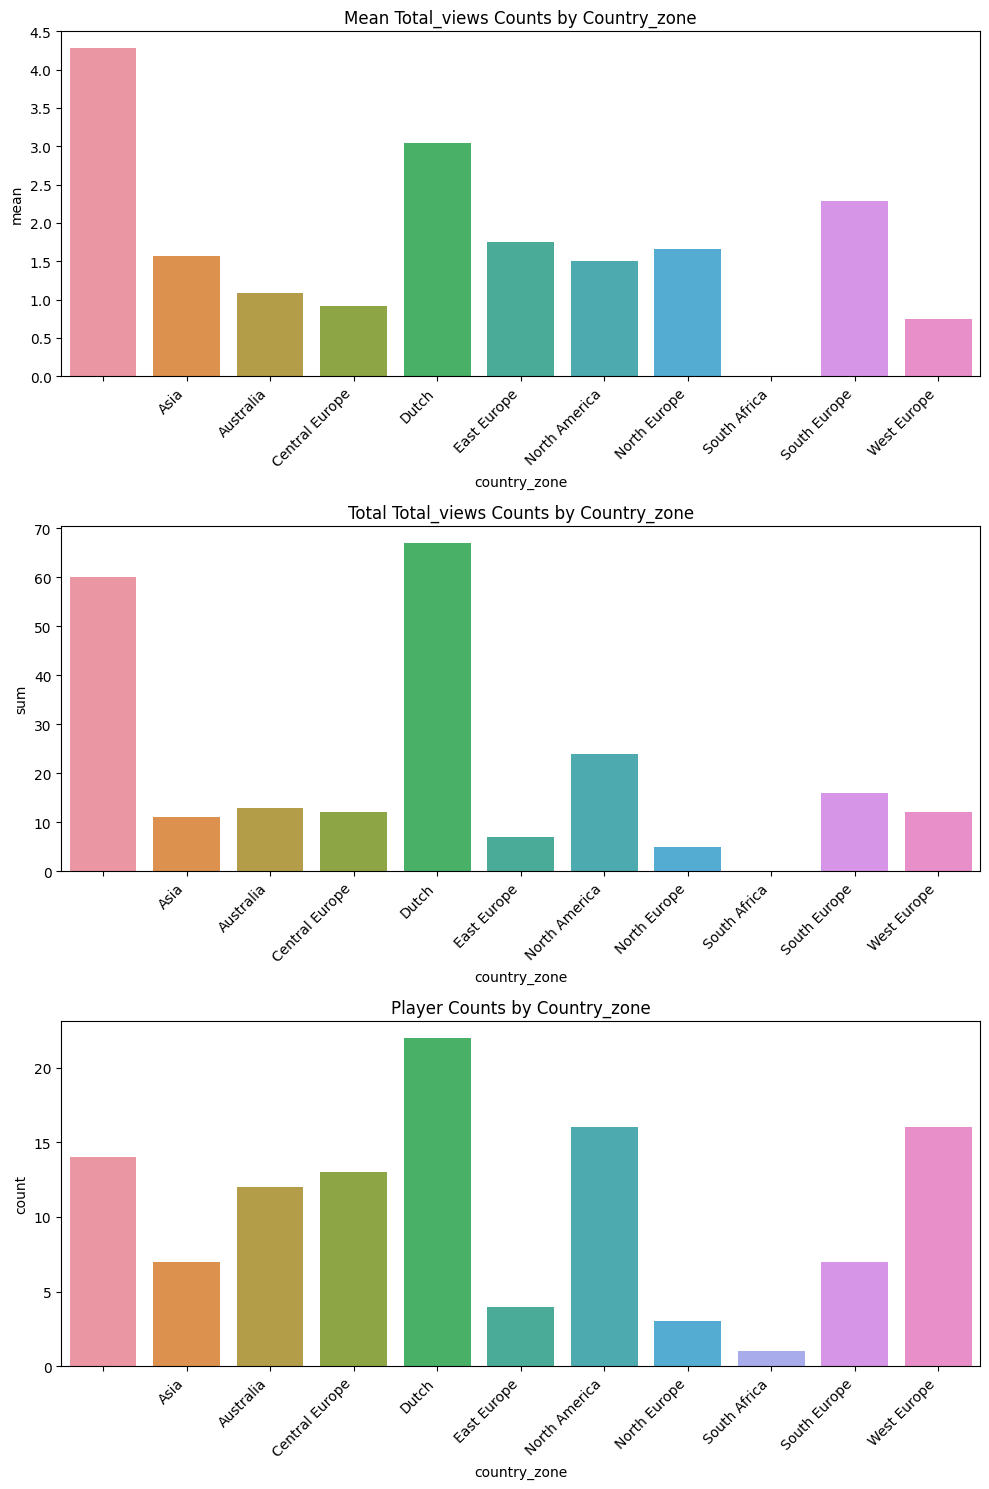

In [28]:
visualize_cat_property(cat_df, 'country_zone', 'total_views')

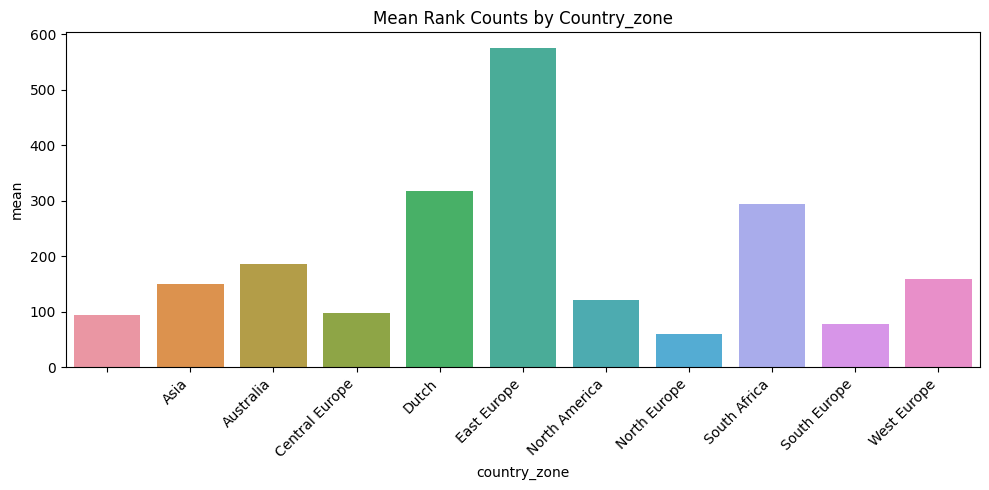

In [29]:
visualize_cat_property(cat_df, 'country_zone', 'rank', types=['mean'])

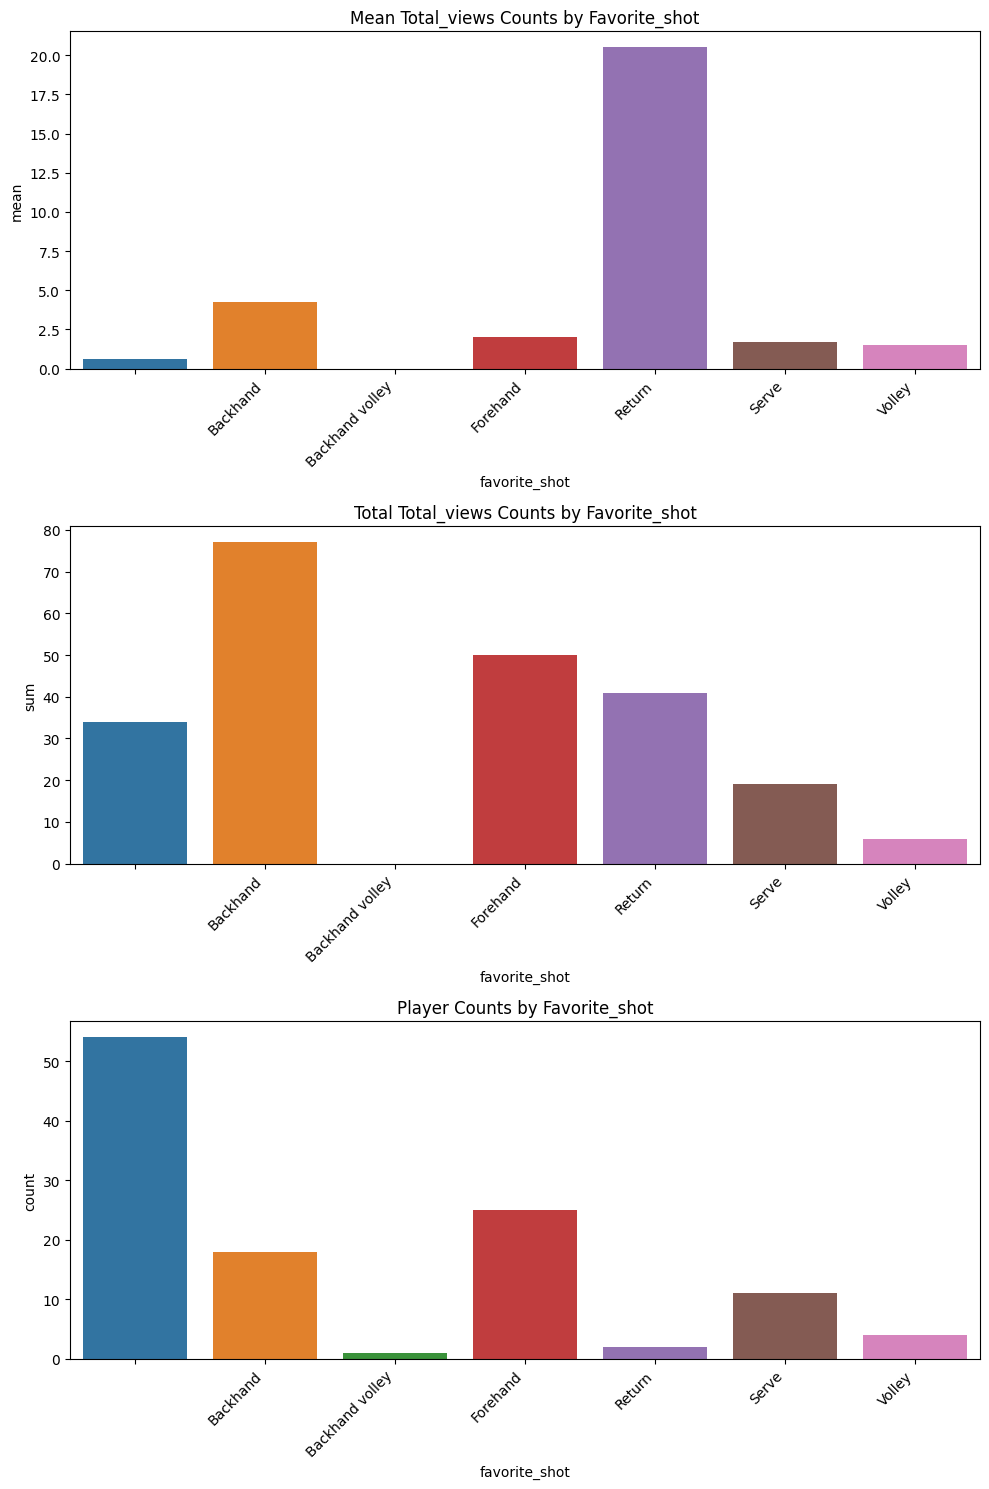

In [30]:
visualize_cat_property(cat_df, 'favorite_shot', 'total_views')

In [31]:
view_counts

{'Daniil Medvedev': {'total': 41,
  'preferences': 1,
  'browsing': 1,
  'browsing/player': 34,
  'browsing/parameter': 5},
 'Elise Mertens': {'total': 34, 'preferences': 4, 'browsing/player': 30},
 'Tallon Griekspoor': {'total': 17,
  'browsing/player': 14,
  'browsing/parameter': 3},
 'Felix Auger-Aliassime': {'total': 12, 'browsing/player': 12},
 'Qinwen Zheng': {'total': 11, 'browsing': 1, 'browsing/player': 10},
 'Jannik Sinner': {'total': 10, 'browsing/player': 10},
 'Belinda Bencic': {'total': 8, 'browsing/player': 8},
 'Alexander Bublik': {'total': 7, 'browsing/player': 7},
 'Alex de Minaur': {'total': 6, 'browsing/player': 6},
 'Emil Ruusuvuori': {'total': 5, 'browsing/player': 5},
 'Karolina Muchova': {'total': 4, 'browsing/player': 4},
 'Bianca Andreescu': {'total': 4, 'browsing/player': 4},
 'Liudmila Samsonova': {'total': 4, 'browsing/player': 4},
 'Varvara Gracheva': {'total': 3, 'browsing': 1, 'browsing/player': 2},
 'Maxime Cressy': {'total': 3, 'browsing/player': 2, 'b

In [32]:
players

{'Mackenzie McDonald': {'name': 'Mackenzie McDonald',
  'country': 'USA',
  'rank': 59,
  'rank_level': 2,
  'status': 'Qualifier',
  'experience': 2,
  'play_style': '',
  'style': None,
  'age': 28,
  'height': 178,
  'favorite_shot': 'Forehand',
  'hand': 'Right-handed',
  'personality_tags': [''],
  'personality_long': '',
  'grass_advantage': False,
  'career_high_rank': 48,
  'years_on_tour': 7,
  'coach': 'Robby Ginepri',
  'image_url': 'https://libema-open.nl/wp-content/uploads/2023/05/mcdonald_full.png',
  'gender': 'Male',
  'country_code': 'US',
  'career_high_year': 2022,
  'previous_libema_winner': False,
  'country_zone': 'North America'},
 'Corentin Moutet': {'name': 'Corentin Moutet',
  'country': 'France',
  'rank': 61,
  'rank_level': 2,
  'status': 'Qualifier',
  'experience': 2,
  'play_style': '',
  'style': None,
  'age': 24,
  'height': 175,
  'favorite_shot': 'Volley',
  'hand': 'Left-handed',
  'personality_tags': [''],
  'personality_long': '',
  'grass_advant

In [33]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Group data by a categorical variable and compute mean view counts
grouped_data = df.groupby('country_zone')['view_count'].mean().reset_index()

# Visualize using a bar plot
plt.figure(figsize=(10, 6))
sns.barplot(x='country_zone', y='view_count', data=grouped_data)
plt.title('Mean View Counts by Country Zone')
plt.show()


KeyError: 'country_zone'

# Categorical Properties

In [1]:
# Get view and like counts
from database_workers.Neo4j_Event_Worker import Event_Worker
event_worker = Event_Worker()
view_counts = event_worker.count_view_player()
like_counts = event_worker.count_like_player()
event_worker.close()
print(len(view_counts))
print(len(like_counts))

45
59


In [2]:
from database_workers.Neo4j_Player_Worker import Player_Worker
# player_names = list(like_counts.keys())
# players = dict()

player_worker = Player_Worker()
# for player in player_names:
    # players[player] = player_worker.get_player_data(player)
players = player_worker.get_all_players_with_personal_data()
player_worker.close()

# Rather than a list of dictionaries, make it a dictionary of dictionaries, with the player name as the key
players_dict = {player['name']: player for player in players}
players_dict

{'Mackenzie McDonald': {'name': 'Mackenzie McDonald',
  'country': 'USA',
  'rank': 59,
  'rank_level': 2,
  'status': 'Qualifier',
  'experience': 2,
  'play_style': '',
  'style': None,
  'age': 28,
  'height': 178,
  'favorite_shot': 'Forehand',
  'hand': 'Right-handed',
  'personality_tags': [''],
  'personality_long': '',
  'grass_advantage': False,
  'career_high_rank': 48,
  'years_on_tour': 7,
  'coach': 'Robby Ginepri',
  'image_url': 'https://libema-open.nl/wp-content/uploads/2023/05/mcdonald_full.png',
  'gender': 'Male',
  'country_code': 'US',
  'career_high_year': 2022,
  'previous_libema_winner': False,
  'country_zone': 'North America'},
 'Corentin Moutet': {'name': 'Corentin Moutet',
  'country': 'France',
  'rank': 61,
  'rank_level': 2,
  'status': 'Qualifier',
  'experience': 2,
  'play_style': '',
  'style': None,
  'age': 24,
  'height': 175,
  'favorite_shot': 'Volley',
  'hand': 'Left-handed',
  'personality_tags': [''],
  'personality_long': '',
  'grass_advant

In [3]:
import pandas as pd

# Convert your dictionary to a DataFrame
df_players = pd.DataFrame(players_dict).T

print(sorted(df_players.keys()))

# # Drop unnecessary columns
df_players = df_players.drop(columns=['name', 'image_url', 'country_code', 'personality_long', 'style', 'status', 'experience', 'personality_tags', 'rank_level'])

# Replace '' values with 'None' for country, play_style, favorite_shot, country_zone
df_players['country'] = df_players['country'].replace('', 'No country')
df_players['play_style'] = df_players['play_style'].replace('', 'Unknown')
df_players['favorite_shot'] = df_players['favorite_shot'].replace('', 'Unknown')
df_players['country_zone'] = df_players['country_zone'].replace('', 'Unknown')
df_players

# Convert view_counts and like_counts into DataFrames
view_counts_df = pd.DataFrame(view_counts).T[['total']].rename(columns={'total': 'views'})
like_counts_df = pd.DataFrame(like_counts).T[['total']].rename(columns={'total': 'likes'})

# Merge the view_counts and like_counts dataframes into the df_players dataframe
df_players = df_players.merge(view_counts_df, how='left', left_index=True, right_index=True)
df_players = df_players.merge(like_counts_df, how='left', left_index=True, right_index=True)

# Fill NA values with 0
df_players[['views', 'likes']] = df_players[['views', 'likes']].fillna(0)

['age', 'career_high_rank', 'career_high_year', 'coach', 'country', 'country_code', 'country_zone', 'experience', 'favorite_shot', 'gender', 'grass_advantage', 'hand', 'height', 'image_url', 'name', 'personality_long', 'personality_tags', 'play_style', 'previous_libema_winner', 'rank', 'rank_level', 'status', 'style', 'years_on_tour']


In [4]:
df_players.head()

,country,rank,play_style,age,height,favorite_shot,hand,grass_advantage,career_high_rank,years_on_tour,coach,gender,career_high_year,previous_libema_winner,country_zone,views,likes
Mackenzie McDonald,USA,59,Unknown,28,178,Forehand,Right-handed,False,48,7,Robby Ginepri,Male,2022,False,North America,0.0,2.0
Corentin Moutet,France,61,Unknown,24,175,Volley,Left-handed,True,51,7,Petar Popovic,Male,2022,False,West Europe,0.0,1.0
Max Purcell,Australia,67,Unknown,25,185,Backhand,Right-handed,True,67,7,Dayne Kelly,Male,2023,False,Australia,1.0,0.0
Jason Kubler,Australia,69,Unknown,30,178,Forehand,Right-handed,False,63,12,"Jarrad Bunt, Stephen Huss",Male,2023,False,Australia,0.0,2.0
Jordan Thompson,Australia,76,Unknown,29,183,Unknown,Right-handed,True,43,10,Peter Luczak,Male,2019,False,Australia,2.0,1.0


In [5]:
df_players.loc['Daniil Medvedev']

country                        No country
rank                                    2
play_style                Counter puncher
age                                    27
height                                198
favorite_shot                      Return
hand                         Right-handed
grass_advantage                     False
career_high_rank                        1
years_on_tour                           9
coach                      Gilles Cervara
gender                               Male
career_high_year                     2022
previous_libema_winner              False
country_zone                      Unknown
views                                41.0
likes                                20.0
Name: Daniil Medvedev, dtype: object

In [6]:
# show NaN values in each column
df_players.isnull().sum()

country                   0
rank                      0
play_style                0
age                       0
height                    0
favorite_shot             0
hand                      0
grass_advantage           0
career_high_rank          0
years_on_tour             0
coach                     0
gender                    0
career_high_year          0
previous_libema_winner    0
country_zone              0
views                     0
likes                     0
dtype: int64

In [7]:
# Edit
# Turn empty string in grass_advantage column to False
df_players.loc[df_players['grass_advantage'] == '', 'grass_advantage'] = False

In [8]:
# Create a copy of the dataframe
df_copy = df_players.copy()

# Initialize a dictionary to keep track of label encoding mappings
label_encodings = {}

# Use LabelEncoder for categorical columns
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

categorical_cols = ['country', 'play_style', 'favorite_shot', 'hand', 'coach', 'gender', 'country_zone']
for col in categorical_cols:
    # Fit transform the data
    df_copy[col] = le.fit_transform(df_copy[col])
    
    # Store the encoding mapping for this column
    label_encodings[col] = dict(zip(le.classes_, le.transform(le.classes_)))

# Print the label encoding mappings
for col, mapping in label_encodings.items():
    print(f"{col}: {mapping}")

# Coerce boolean columns to int
boolean_cols = ['grass_advantage', 'previous_libema_winner']
df_copy[boolean_cols] = df_copy[boolean_cols].astype(int)

# Print the datatypes after conversion
print("\nData types after conversion:")
print(df_copy.dtypes)


country: {'Australia': 0, 'Belgium': 1, 'Canada': 2, 'China': 3, 'Croatia': 4, 'Cyprus': 5, 'Czech Republic': 6, 'Finland': 7, 'France': 8, 'Georgia': 9, 'Germany': 10, 'Hungary': 11, 'India': 12, 'Israel': 13, 'Italy': 14, 'Japan': 15, 'Kazakhstan': 16, 'Lithuania': 17, 'Netherlands': 18, 'New Zealand': 19, 'No country': 20, 'Serbia': 21, 'Slovakia': 22, 'Slovenia': 23, 'South Africa': 24, 'Spain': 25, 'Sweden': 26, 'Switzerland': 27, 'Turkey': 28, 'USA': 29, 'Ukraine': 30}
play_style: {'Aggressive baseliner': 0, 'All-court player': 1, 'Counter puncher': 2, 'Serve and volley': 3, 'Unknown': 4}
favorite_shot: {'Backhand': 0, 'Backhand volley': 1, 'Forehand': 2, 'Return': 3, 'Serve': 4, 'Unknown': 5, 'Volley': 6}
hand: {'': 0, 'Left-Handed': 1, 'Left-handed': 2, 'Right-handed': 3}
coach: {'': 0, 'Adolfo Gutierrez': 1, 'Adrian Zeman': 2, 'Alessandro Dumitrache': 3, 'Alexander Kneepkens': 4, 'Alexandre Sidorenko, Juanjo Climent, Andrew Mawire ': 5, 'Ann Devries': 6, 'Anthony Harris': 7, '

In [9]:
numeric_cols = ['rank', 'age', 'height', 'career_high_rank', 'years_on_tour', 'career_high_year']

df_copy[numeric_cols] = df_copy[numeric_cols].apply(pd.to_numeric, errors='coerce')


In [10]:
mean_views = df_players['views'].mean()
var_views = df_players['views'].var()

print(f'Mean of views: {mean_views}')
print(f'Variance of views: {var_views}')

mean_likes = df_players['likes'].mean()
var_likes= df_players['likes'].var()

print(f'Mean of likes: {mean_likes}')
print(f'Variance of likes: {var_likes}')


Mean of views: 1.9739130434782608
Variance of views: 29.937909992372234
Mean of likes: 1.8869565217391304
Variance of likes: 12.662547673531659


In [11]:
import statsmodels.api as sm

# We use a negative binomial distribution because the variance of the data is greater than the mean

# Assume df is your DataFrame, 'views' is your outcome variable, and 'predictors' is a list of your predictors
df_copy['intercept'] = 1
predictors = ['intercept', 'country', 'rank', 'play_style', 'age', 'height', 'favorite_shot', 'hand', 
              'grass_advantage', 'career_high_rank', 'years_on_tour', 'coach', 'gender', 
              'career_high_year', 'previous_libema_winner', 'country_zone']

# Fit the model on views
view_categorical_regression = sm.GLM(df_copy['views'], df_copy[predictors], family=sm.families.NegativeBinomial()).fit()

# Fit the model on likes
like_categorical_regression = sm.GLM(df_copy['likes'], df_copy[predictors], family=sm.families.NegativeBinomial()).fit()

# Print the summary statistics of the regression model
print(view_categorical_regression.summary())
print(like_categorical_regression.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                  views   No. Observations:                  115
Model:                            GLM   Df Residuals:                       99
Model Family:        NegativeBinomial   Df Model:                           15
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -156.75
Date:                Tue, 08 Aug 2023   Deviance:                       109.59
Time:                        17:36:07   Pearson chi2:                     151.
No. Iterations:                    23   Pseudo R-squ. (CS):             0.6576
Covariance Type:            nonrobust                                         
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
intercept                -19

/home/musashishi/Thesis/tennis-router/backend/venv/lib/python3.10/site-packages/statsmodels/genmod/families/family.py:1367: ValueWarning: Negative binomial dispersion parameter alpha not set. Using default value alpha=1.0.
  warnings.warn("Negative binomial dispersion parameter alpha not "
/home/musashishi/Thesis/tennis-router/backend/venv/lib/python3.10/site-packages/statsmodels/genmod/families/family.py:1367: ValueWarning: Negative binomial dispersion parameter alpha not set. Using default value alpha=1.0.
  warnings.warn("Negative binomial dispersion parameter alpha not "


In [21]:
# Save model summary to a file
with open('./results/view_categorical_regression.tex', 'w') as f:
    f.write(view_categorical_regression.summary().as_latex())

with open('./results/like_categorical_regression.txt', 'w') as f:
    f.write(like_categorical_regression.summary().as_latex())

# Personality tags

In [13]:
from database_workers.Neo4j_Player_Worker import Player_Worker
# player_names = list(like_counts.keys())
# players = dict()

player_worker = Player_Worker()
# for player in player_names:
    # players[player] = player_worker.get_player_data(player)
players = player_worker.get_all_players_with_personal_data()
player_worker.close()

# Rather than a list of dictionaries, make it a dictionary of dictionaries, with the player name as the key
players_dict = {player['name']: player for player in players}
players_dict

{'Mackenzie McDonald': {'name': 'Mackenzie McDonald',
  'country': 'USA',
  'rank': 59,
  'rank_level': 2,
  'status': 'Qualifier',
  'experience': 2,
  'play_style': '',
  'style': None,
  'age': 28,
  'height': 178,
  'favorite_shot': 'Forehand',
  'hand': 'Right-handed',
  'personality_tags': [''],
  'personality_long': '',
  'grass_advantage': False,
  'career_high_rank': 48,
  'years_on_tour': 7,
  'coach': 'Robby Ginepri',
  'image_url': 'https://libema-open.nl/wp-content/uploads/2023/05/mcdonald_full.png',
  'gender': 'Male',
  'country_code': 'US',
  'career_high_year': 2022,
  'previous_libema_winner': False,
  'country_zone': 'North America'},
 'Corentin Moutet': {'name': 'Corentin Moutet',
  'country': 'France',
  'rank': 61,
  'rank_level': 2,
  'status': 'Qualifier',
  'experience': 2,
  'play_style': '',
  'style': None,
  'age': 24,
  'height': 175,
  'favorite_shot': 'Volley',
  'hand': 'Left-handed',
  'personality_tags': [''],
  'personality_long': '',
  'grass_advant

In [14]:
# Check view_player counts
from database_workers.Neo4j_Event_Worker import Event_Worker
event_worker = Event_Worker()
view_counts = event_worker.count_view_player()
like_counts = event_worker.count_like_player()
event_worker.close()
print(len(view_counts))
print(len(like_counts))

45
59


In [15]:
import pandas as pd

# Convert your dictionary to a DataFrame
df_players = pd.DataFrame(players_dict).T


# # Drop unnecessary columns
df_players = df_players[['name', 'personality_tags']]

print(sorted(df_players.keys()))

# Convert view_counts and like_counts into DataFrames
view_counts_df = pd.DataFrame(view_counts).T[['total']].rename(columns={'total': 'views'})
like_counts_df = pd.DataFrame(like_counts).T[['total']].rename(columns={'total': 'likes'})

# Merge the view_counts and like_counts dataframes into the df_players dataframe
df_players = df_players.merge(view_counts_df, how='left', left_index=True, right_index=True)
df_players = df_players.merge(like_counts_df, how='left', left_index=True, right_index=True)

# Fill NA values with 0
df_players[['views', 'likes']] = df_players[['views', 'likes']].fillna(0)
df_players.reset_index(inplace=True)
df_players.drop(columns=['index'], inplace=True)

['name', 'personality_tags']


In [16]:
df_players
# Type of personality_tags column
type(df_players['personality_tags'][:-1])

pandas.core.series.Series

In [17]:
import pandas as pd

# Load the excel file
tag_categories = pd.read_excel("./data/Tag_Categories.xlsx")

# Create a dictionary where the keys are the keywords and the values are the corresponding categories
tag_dict = dict(zip(tag_categories.Keyword, tag_categories.Category))

# Get the unique category names
unique_categories = tag_categories.Category.unique()

# Initialize new columns for each category in df_players
for category in unique_categories:
    df_players[category] = 0

# Update the counts
for index, row in df_players.iterrows():
    for tag in row["personality_tags"]:
        if tag in tag_dict:  # If the tag is in our dictionary
            category = tag_dict[tag]  # Get the corresponding category
            df_players.loc[index, category] += 1  # Increment the count for that category

print(df_players.iloc[114])
df_players.tail()

name                                                          Jannik Sinner
personality_tags          [calm, all-court player, focused, groundstroke...
views                                                                  10.0
likes                                                                   1.0
Blank                                                                     0
Composed                                                                  7
Offensive play                                                            6
Physical                                                                  3
Ignore                                                                    6
Mental strength                                                           6
Tactical play                                                             6
Competitive                                                               3
Consistent play                                                           3
Defensive pl

,name,personality_tags,views,likes,Blank,Composed,Offensive play,Physical,Ignore,Mental strength,Tactical play,Competitive,Consistent play,Defensive play,Emotionally Expressive,Outgoing personality,Unique,Net play
110,Erin Routliffe,[],0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
111,Laslo Djere,[],1.0,1.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
112,Venus Williams,[],1.0,2.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
113,Lucrezia Stefanini,[],0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
114,Jannik Sinner,"[calm, all-court player, focused, groundstroke...",10.0,1.0,0,7,6,3,6,6,6,3,3,0,0,0,0,0


In [18]:
# Testing the above block (this checks out, I checked with the Excel sheet)
# Get the row index where the name is Daniil Medvedev of df_players
print("Daniil's index:", df_players[df_players['name'] == 'Daniil Medvedev'].index[0])
print(df_players.iloc[36]['personality_tags'])
df_players.iloc[36]

Daniil's index: 36
['funny', 'outspoken', 'analytical', 'unorthodox', 'defensive baseliner']


name                                                        Daniil Medvedev
personality_tags          [funny, outspoken, analytical, unorthodox, def...
views                                                                  41.0
likes                                                                  20.0
Blank                                                                     0
Composed                                                                  0
Offensive play                                                            0
Physical                                                                  0
Ignore                                                                    0
Mental strength                                                           1
Tactical play                                                             0
Competitive                                                               0
Consistent play                                                           0
Defensive pl

In [19]:
# The regression
import statsmodels.api as sm

# List of predictors (personality tag categories)
predictors = ['Blank', 'Composed', 'Offensive play', 'Physical', 'Ignore', 'Mental strength', 'Tactical play',
              'Competitive', 'Consistent play', 'Defensive play', 'Emotionally Expressive', 'Outgoing personality',
              'Unique', 'Net play']

# Add a constant to the predictors
df_players['intercept'] = 1
predictors = ['intercept'] + predictors

# Fit the model for 'views'
view_tags_model = sm.GLM(df_players['views'], df_players[predictors], family=sm.families.NegativeBinomial()).fit()

# Print the summary statistics of the regression model
print(view_tags_model.summary())

# Fit the model for 'likes'
like_tags_model = sm.GLM(df_players['likes'], df_players[predictors], family=sm.families.NegativeBinomial()).fit()

# Print the summary statistics of the regression model
print(like_tags_model.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                  views   No. Observations:                  115
Model:                            GLM   Df Residuals:                      101
Model Family:        NegativeBinomial   Df Model:                           13
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -154.23
Date:                Tue, 08 Aug 2023   Deviance:                       104.55
Time:                        17:36:11   Pearson chi2:                     113.
No. Iterations:                    69   Pseudo R-squ. (CS):             0.6723
Covariance Type:            nonrobust                                         
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
intercept                 -0

/home/musashishi/Thesis/tennis-router/backend/venv/lib/python3.10/site-packages/statsmodels/genmod/families/family.py:1367: ValueWarning: Negative binomial dispersion parameter alpha not set. Using default value alpha=1.0.
  warnings.warn("Negative binomial dispersion parameter alpha not "
/home/musashishi/Thesis/tennis-router/backend/venv/lib/python3.10/site-packages/statsmodels/genmod/families/family.py:1367: ValueWarning: Negative binomial dispersion parameter alpha not set. Using default value alpha=1.0.
  warnings.warn("Negative binomial dispersion parameter alpha not "


In [20]:
# Save model summary to a file
with open('./results/view_personality_tag_regression.tex', 'w') as f:
    f.write(view_tags_model.summary().as_latex())

with open('./results/like_personality_tag_regression.tex', 'w') as f:
    f.write(like_tags_model.summary().as_latex())

# Check defining properties of players who have likes but no views using regression on ALL properties together

In [31]:
from database_workers.Neo4j_Player_Worker import Player_Worker
# player_names = list(like_counts.keys())
# players = dict()

player_worker = Player_Worker()
# for player in player_names:
    # players[player] = player_worker.get_player_data(player)
players = player_worker.get_all_players_with_personal_data()
player_worker.close()

# Rather than a list of dictionaries, make it a dictionary of dictionaries, with the player name as the key
players_dict = {player['name']: player for player in players}
players_dict

{'Mackenzie McDonald': {'name': 'Mackenzie McDonald',
  'country': 'USA',
  'rank': 59,
  'rank_level': 2,
  'status': 'Qualifier',
  'experience': 2,
  'play_style': '',
  'style': None,
  'age': 28,
  'height': 178,
  'favorite_shot': 'Forehand',
  'hand': 'Right-handed',
  'personality_tags': [''],
  'personality_long': '',
  'grass_advantage': False,
  'career_high_rank': 48,
  'years_on_tour': 7,
  'coach': 'Robby Ginepri',
  'image_url': 'https://libema-open.nl/wp-content/uploads/2023/05/mcdonald_full.png',
  'gender': 'Male',
  'country_code': 'US',
  'career_high_year': 2022,
  'previous_libema_winner': False,
  'country_zone': 'North America'},
 'Corentin Moutet': {'name': 'Corentin Moutet',
  'country': 'France',
  'rank': 61,
  'rank_level': 2,
  'status': 'Qualifier',
  'experience': 2,
  'play_style': '',
  'style': None,
  'age': 24,
  'height': 175,
  'favorite_shot': 'Volley',
  'hand': 'Left-handed',
  'personality_tags': [''],
  'personality_long': '',
  'grass_advant

In [32]:
# Check view_player counts
from database_workers.Neo4j_Event_Worker import Event_Worker
event_worker = Event_Worker()
view_counts = event_worker.count_view_player()
like_counts = event_worker.count_like_player()
event_worker.close()
print(len(view_counts))
print(len(like_counts))

45
59


# Multi Collinearity analysis (VIF)

In [1]:
from database_workers.Neo4j_Player_Worker import Player_Worker
# player_names = list(like_counts.keys())
# players = dict()

player_worker = Player_Worker()
# for player in player_names:
    # players[player] = player_worker.get_player_data(player)
players = player_worker.get_all_players_with_personal_data()
player_worker.close()

# Rather than a list of dictionaries, make it a dictionary of dictionaries, with the player name as the key
players_dict = {player['name']: player for player in players}
players_dict

{'Mackenzie McDonald': {'name': 'Mackenzie McDonald',
  'country': 'USA',
  'rank': 59,
  'rank_level': 2,
  'status': 'Qualifier',
  'experience': 2,
  'play_style': '',
  'style': None,
  'age': 28,
  'height': 178,
  'favorite_shot': 'Forehand',
  'hand': 'Right-handed',
  'personality_tags': [''],
  'personality_long': '',
  'grass_advantage': False,
  'career_high_rank': 48,
  'years_on_tour': 7,
  'coach': 'Robby Ginepri',
  'image_url': 'https://libema-open.nl/wp-content/uploads/2023/05/mcdonald_full.png',
  'gender': 'Male',
  'country_code': 'US',
  'career_high_year': 2022,
  'previous_libema_winner': False,
  'country_zone': 'North America'},
 'Corentin Moutet': {'name': 'Corentin Moutet',
  'country': 'France',
  'rank': 61,
  'rank_level': 2,
  'status': 'Qualifier',
  'experience': 2,
  'play_style': '',
  'style': None,
  'age': 24,
  'height': 175,
  'favorite_shot': 'Volley',
  'hand': 'Left-handed',
  'personality_tags': [''],
  'personality_long': '',
  'grass_advant

In [2]:
# Label encode the stuff
import pandas as pd
from sklearn.preprocessing import LabelEncoder

# Convert the dictionary to a DataFrame
players_df = pd.DataFrame(players_dict).T

# Remove name column and reset index
players_df.reset_index(inplace=True)
players_df.drop(columns=["name", "index", "rank_level", "experience", "style", "personality_tags", "personality_long", "image_url", "country_code"], inplace=True)
players_df

# Apply label encoding to all columns that have object data type
label_encoders = {}  # This will store each encoder, in case you need inverse transformation later
for column in players_df.select_dtypes(include=['object']).columns:
    le = LabelEncoder()
    players_df[column] = le.fit_transform(players_df[column].astype(str))
    label_encoders[column] = le

players_df

,country,rank,status,play_style,age,height,favorite_shot,hand,grass_advantage,career_high_rank,years_on_tour,coach,gender,career_high_year,previous_libema_winner,country_zone
0,29,77,3,0,11,11,3,3,1,62,18,73,1,9,0,6
1,9,81,3,0,7,10,6,2,2,64,18,65,1,9,0,10
2,1,84,1,0,8,18,1,3,2,72,18,19,1,10,0,2
3,1,85,3,0,13,11,3,3,1,71,4,45,1,10,0,2
4,1,89,3,0,12,16,0,3,2,58,2,67,1,6,0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
110,20,76,1,0,11,15,0,3,1,68,4,0,0,10,0,2
111,21,79,0,0,11,20,3,3,1,46,2,44,1,6,0,3
112,29,86,2,0,20,18,0,3,1,0,13,25,0,0,0,6
113,15,4,0,0,8,2,1,3,1,3,19,29,0,10,0,9


In [3]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
# Check the multicollinearity with VIF
vif_data = pd.DataFrame()
vif_data["feature"] = players_df.columns

vif_data["VIF"] = [variance_inflation_factor(players_df.values, i) if len(players_df[column].unique()) > 1 else 0 for i, column in enumerate(players_df.columns)]
vif_data

,feature,VIF
0,country,3.401230
1,rank,4.965289
2,status,2.074269
3,play_style,1.849639
4,age,8.461222
5,height,13.535772
6,favorite_shot,2.521747
7,hand,13.564423
8,grass_advantage,11.935402
9,career_high_rank,5.338520


# Check players who have views but no likes

# Check players who have no views or likes

# Check all properties in regression (including numeric and personality tags)

# Todo check all properties in regression but remove players who have 0 values for view or like

# Todo save players as viewable table with all their properties, sorted on like count and then on view count